In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
df = pd.read_csv('clean data.csv')

In [3]:
df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')

In [4]:
df.head()

,record,card,date,merch#,merchdes,merchstate,merchzip,transtype,amount,fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0


In [5]:
df.dtypes

record                 int64
card                   int64
date          datetime64[ns]
merch#                object
merchdes              object
merchstate            object
merchzip               int64
transtype             object
amount               float64
fraud                  int64
dtype: object

In [6]:
df.shape

(96397, 10)

# 1. Create combination groups

In [7]:
df.columns

Index(['record', 'card', 'date', 'merch#', 'merchdes', 'merchstate',
       'merchzip', 'transtype', 'amount', 'fraud'],
      dtype='object')

In [8]:
df['card-merchant'] = df['card'].astype(str) + '-' + df['merch#']
df['card-zip'] = df['card'].astype(str) + '-' + df['merchzip'].astype(str)
df['card-state'] = df['card'].astype(str) + '-' + df['merchstate']

In [9]:
df

,record,card,date,merch#,merchdes,merchstate,merchzip,transtype,amount,fraud,card-merchant,card-zip,card-state
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,5142190439-5509006296254,5142190439-38118,5142190439-TN
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,5142183973-61003026333,5142183973-1803,5142183973-MA
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,5142131721-4503082993600,5142131721-20706,5142131721-MD
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,5142148452-5509006296254,5142148452-38118,5142148452-TN
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,5142190439-5509006296254,5142190439-38118,5142190439-TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042,P,84.79,0,5142276053-3500000006160,5142276053-41042,5142276053-KY
96393,96750,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0,5142225701-8090710030950,5142225701-45248,5142225701-OH
96394,96751,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150,P,363.56,0,5142226486-4503057341100,5142226486-45150,5142226486-OH
96395,96752,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0,5142244619-8834000695412,5142244619-92656,5142244619-CA


# 2. Create 4 types of variables

In [10]:
df.columns

Index(['record', 'card', 'date', 'merch#', 'merchdes', 'merchstate',
       'merchzip', 'transtype', 'amount', 'fraud', 'card-merchant', 'card-zip',
       'card-state'],
      dtype='object')

In [11]:
attributes = list(df.columns)
for col in ['record', 'date', 'merchdes', 'merchstate', 'merchzip', 'transtype', 'amount', 'fraud']:
    attributes.remove(col)
print(attributes)

['card', 'merch#', 'card-merchant', 'card-zip', 'card-state']


In [24]:
finalDF = df[['record','date','amount']]

for val in attributes:
    df1 = df[['record','date','amount', val]].copy()
    df2 = df1.copy()
    lags = [0, 1, 3, 7, 14, 30]
    
    ##### 1. days_since variables #####
    for lag in lags:
        date_lags = 'date_{}'.format(lag)
        df2[date_lags] = df2['date'] + dt.timedelta(lag)

    df3 = df1.merge(df2, on=val)

    tmp = df3[(df3['record_x']>df3['record_y'])][['record_x','date_y']].\
          groupby('record_x').last()['date_y'].reset_index()
    tmp.columns = ['record','last_seen']
    df1 = df1.merge(tmp, how='left', on='record')
    df1['#d_since'] = df1['date'] - df1['last_seen']
    df1['#d_since'] = df1['#d_since'].dt.days
    df1['#d_since_start'] = (df1['date']-df1['date'].min()).dt.days
    df1['#d_since'] = df1['#d_since'].fillna(df1['#d_since_start'])
    
    df1.drop(columns=['last_seen','#d_since_start'], inplace=True)

    ##### 2. frequency variables #####
    for lag in lags:
        temp = df3[(df3['record_x']>=df3['record_y']) & (df3['date_x']<=df3['date_{}'.format(lag)])]
        tempCount = temp[['record_x','record_y']].groupby('record_x').count().reset_index()
        date_lags = 'ps_{}d_count'.format(lag)
        tempCount.columns = ['record', date_lags] 
        df1 = df1.merge(tempCount, left_on='record',right_on='record')
            
    ##### 3. amount variables #####
    for lag in lags:
        temp = df3[(df3['record_x']>=df3['record_y']) & (df3['date_x']<=df3['date_{}'.format(lag)])]
        
        # average
        tempAverage = temp[['amount_x']].groupby(temp['record_x']).mean().reset_index()
        date_lags_average = 'ps_{}d_average'.format(lag)
        tempAverage.columns = ['record', date_lags_average]
        df1 = df1.merge(tempAverage, left_on='record',right_on='record')
        
        # maximum
        tempMaximum = temp[['amount_x']].groupby(temp['record_x']).max().reset_index()
        date_lags_maximum = 'ps_{}d_maximum'.format(lag)
        tempMaximum.columns = ['record', date_lags_maximum]
        df1 = df1.merge(tempMaximum, left_on='record',right_on='record')
        
        # median
        tempMedian = temp[['amount_x']].groupby(temp['record_x']).median().reset_index()
        date_lags_median = 'ps_{}d_median'.format(lag)
        tempMedian.columns = ['record', date_lags_median]
        df1 = df1.merge(tempMedian, left_on='record',right_on='record')
        
        # total
        tempSum = temp[['amount_x']].groupby(temp['record_x']).sum().reset_index()
        date_lags_total = 'ps_{}d_total'.format(lag)
        tempSum.columns = ['record', date_lags_total]
        df1 = df1.merge(tempSum, left_on='record',right_on='record')
        
        # actual/average
        date_lags_ActualAverage = 'ps_{}d_ActualAverage'.format(lag)
        denominator_Average = 'ps_{}d_average'.format(lag)
        df1[date_lags_ActualAverage] = df1['amount'] / df1[denominator_Average]
        
        # actual/maximum
        date_lags_ActualMaximum = 'ps_{}d_ActualMaximum'.format(lag)
        denominator_Maximum = 'ps_{}d_maximum'.format(lag)
        df1[date_lags_ActualMaximum] = df1['amount'] / df1[denominator_Maximum]

        # actual/median
        date_lags_ActualMedian = 'ps_{}d_ActualMedian'.format(lag)
        denominator_Median = 'ps_{}d_median'.format(lag)
        df1[date_lags_ActualMedian] = df1['amount'] / df1[denominator_Median]
    
        # actual/total
        date_lags_ActualTotal = 'ps_{}d_ActualTotal'.format(lag)
        denominator_Total = 'ps_{}d_total'.format(lag)
        df1[date_lags_ActualTotal] = df1['amount'] / df1[denominator_Total]
        
    ##### 4. velocity change variables #####
    # number
    for i in [0, 1]:
        for j in [7, 14, 30]:
            date_lags_number = 'ps_{}d_ps{}d_number'.format(i,j)
            numerator = 'ps_{}d_count'.format(i)
            denominator = 'ps_{}d_count'.format(j)
            df1[date_lags_number] = df1[numerator] / (df1[denominator]/j)
        
    # amount
    for i in [0, 1]:
        for j in [7, 14, 30]:
            date_lags_amount = 'ps_{}d_ps{}d_amount'.format(i,j)
            numerator = 'ps_{}d_average'.format(i)
            denominator = 'ps_{}d_average'.format(j)
            df1[date_lags_amount] = df1[numerator] / (df1[denominator])

    df1.drop(columns=['date',val], inplace=True)
    df1 = df1.set_index('record')
    df1 = df1.add_prefix('{}_'.format(val))
    finalDF = finalDF.merge(df1, left_on='record', right_index=True)

In [25]:
co = list(finalDF.columns)
co

['record',
 'date',
 'amount',
 'card_amount',
 'card_#d_since',
 'card_ps_0d_count',
 'card_ps_1d_count',
 'card_ps_3d_count',
 'card_ps_7d_count',
 'card_ps_14d_count',
 'card_ps_30d_count',
 'card_ps_0d_average',
 'card_ps_0d_maximum',
 'card_ps_0d_median',
 'card_ps_0d_total',
 'card_ps_0d_ActualAverage',
 'card_ps_0d_ActualMaximum',
 'card_ps_0d_ActualMedian',
 'card_ps_0d_ActualTotal',
 'card_ps_1d_average',
 'card_ps_1d_maximum',
 'card_ps_1d_median',
 'card_ps_1d_total',
 'card_ps_1d_ActualAverage',
 'card_ps_1d_ActualMaximum',
 'card_ps_1d_ActualMedian',
 'card_ps_1d_ActualTotal',
 'card_ps_3d_average',
 'card_ps_3d_maximum',
 'card_ps_3d_median',
 'card_ps_3d_total',
 'card_ps_3d_ActualAverage',
 'card_ps_3d_ActualMaximum',
 'card_ps_3d_ActualMedian',
 'card_ps_3d_ActualTotal',
 'card_ps_7d_average',
 'card_ps_7d_maximum',
 'card_ps_7d_median',
 'card_ps_7d_total',
 'card_ps_7d_ActualAverage',
 'card_ps_7d_ActualMaximum',
 'card_ps_7d_ActualMedian',
 'card_ps_7d_ActualTotal',

In [26]:
len(co)

343

In [27]:
finalDF

,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,card_ps_14d_count,...,card-state_ps_0d_ps30d_number,card-state_ps_1d_ps7d_number,card-state_ps_1d_ps14d_number,card-state_ps_1d_ps30d_number,card-state_ps_0d_ps7d_amount,card-state_ps_0d_ps14d_amount,card-state_ps_0d_ps30d_amount,card-state_ps_1d_ps7d_amount,card-state_ps_1d_ps14d_amount,card-state_ps_1d_ps30d_amount
0,1,2010-01-01,3.62,3.62,0.0,1,1,1,1,1,...,30.0,7.00,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,1,...,30.0,7.00,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,1,...,30.0,7.00,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4,2010-01-01,3.62,3.62,0.0,1,1,1,1,1,...,30.0,7.00,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
4,5,2010-01-01,3.62,3.62,0.0,2,2,2,2,2,...,30.0,7.00,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,2010-12-31,84.79,84.79,37.0,1,1,1,1,1,...,30.0,7.00,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
96393,96750,2010-12-31,118.75,118.75,0.0,2,2,5,5,13,...,7.5,3.50,3.5,7.5,1.0,1.0,1.0,1.0,1.0,1.0
96394,96751,2010-12-31,363.56,363.56,1.0,1,3,5,6,6,...,15.0,7.00,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
96395,96752,2010-12-31,2202.03,2202.03,9.0,1,1,1,1,3,...,10.0,7.00,14.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0


In [28]:
finalDF.to_csv('half-result.csv')

In [29]:
data = finalDF
data.head()

,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,card_ps_14d_count,...,card-state_ps_0d_ps30d_number,card-state_ps_1d_ps7d_number,card-state_ps_1d_ps14d_number,card-state_ps_1d_ps30d_number,card-state_ps_0d_ps7d_amount,card-state_ps_0d_ps14d_amount,card-state_ps_0d_ps30d_amount,card-state_ps_1d_ps7d_amount,card-state_ps_1d_ps14d_amount,card-state_ps_1d_ps30d_amount
0,1,2010-01-01,3.62,3.62,0.0,1,1,1,1,1,...,30.0,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,1,...,30.0,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,1,...,30.0,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4,2010-01-01,3.62,3.62,0.0,1,1,1,1,1,...,30.0,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
4,5,2010-01-01,3.62,3.62,0.0,2,2,2,2,2,...,30.0,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0


# 3. Create Benford's Law variable

## a. Remove Fedex transactions

In [131]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [132]:
data=pd.read_csv('half-result.csv')
# df = pd.read_csv('clean data.csv')

In [133]:
data.head()

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,card-state_ps_0d_ps30d_number,card-state_ps_1d_ps7d_number,card-state_ps_1d_ps14d_number,card-state_ps_1d_ps30d_number,card-state_ps_0d_ps7d_amount,card-state_ps_0d_ps14d_amount,card-state_ps_0d_ps30d_amount,card-state_ps_1d_ps7d_amount,card-state_ps_1d_ps14d_amount,card-state_ps_1d_ps30d_amount
0,0,1,2010-01-01,3.62,3.62,0.0,1,1,1,1,...,30.0,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,30.0,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,30.0,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3,4,2010-01-01,3.62,3.62,0.0,1,1,1,1,...,30.0,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4,5,2010-01-01,3.62,3.62,0.0,2,2,2,2,...,30.0,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0


In [134]:
import re

In [135]:
data['merchdes'] = df['merchdes']
data.head()

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,card-state_ps_1d_ps7d_number,card-state_ps_1d_ps14d_number,card-state_ps_1d_ps30d_number,card-state_ps_0d_ps7d_amount,card-state_ps_0d_ps14d_amount,card-state_ps_0d_ps30d_amount,card-state_ps_1d_ps7d_amount,card-state_ps_1d_ps14d_amount,card-state_ps_1d_ps30d_amount,merchdes
0,0,1,2010-01-01,3.62,3.62,0.0,1,1,1,1,...,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/23/09 AB#
1,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,SERVICE MERCHANDISE #81
2,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,OFFICE DEPOT #191
3,3,4,2010-01-01,3.62,3.62,0.0,1,1,1,1,...,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/28/09 AB#
4,4,5,2010-01-01,3.62,3.62,0.0,2,2,2,2,...,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/23/09 AB#


In [136]:
fedex = []
merchdes_lower=data.merchdes.str.lower()
for des in merchdes_lower:
    result = re.findall(r'\bfed.*ex\b', des)
    if result != []:
        fedex.append(des)

In [137]:
set(fedex)

{'fed ex #16',
 'fedex danger gds seminar',
 'fedex sameday service',
 'fedex shp 01/03/10 ab#',
 'fedex shp 01/04/10 ab#',
 'fedex shp 01/05/10 ab#',
 'fedex shp 01/06/10 ab#',
 'fedex shp 01/07/10 ab#',
 'fedex shp 01/10/10 ab#',
 'fedex shp 01/11/10 ab#',
 'fedex shp 01/12/10 ab#',
 'fedex shp 01/13/10 ab#',
 'fedex shp 01/14/10 ab#',
 'fedex shp 01/17/10 ab#',
 'fedex shp 01/18/10 ab#',
 'fedex shp 01/19/10 ab#',
 'fedex shp 01/20/10 ab#',
 'fedex shp 01/21/10 ab#',
 'fedex shp 01/22/10 ab#',
 'fedex shp 01/24/10 ab#',
 'fedex shp 01/25/10 ab#',
 'fedex shp 01/26/10 ab#',
 'fedex shp 01/27/10 ab#',
 'fedex shp 01/28/10 ab#',
 'fedex shp 01/29/10 ab#',
 'fedex shp 01/31/10 ab#',
 'fedex shp 02/01/10 ab#',
 'fedex shp 02/02/10 ab#',
 'fedex shp 02/03/10 ab#',
 'fedex shp 02/04/10 ab#',
 'fedex shp 02/07/10 ab#',
 'fedex shp 02/08/10 ab#',
 'fedex shp 02/09/10 ab#',
 'fedex shp 02/10/10 ab#',
 'fedex shp 02/11/10 ab#',
 'fedex shp 02/14/10 ab#',
 'fedex shp 02/15/10 ab#',
 'fedex shp 

In [138]:
clean = data[data['merchdes'].isin([x.upper() for x in fedex])==False].reset_index(inplace=False, drop=True)

In [139]:
data[data['merchdes'].isin([x.upper() for x in fedex])==True]

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,card-state_ps_1d_ps7d_number,card-state_ps_1d_ps14d_number,card-state_ps_1d_ps30d_number,card-state_ps_0d_ps7d_amount,card-state_ps_0d_ps14d_amount,card-state_ps_0d_ps30d_amount,card-state_ps_1d_ps7d_amount,card-state_ps_1d_ps14d_amount,card-state_ps_1d_ps30d_amount,merchdes
0,0,1,2010-01-01,3.62,3.62,0.0,1,1,1,1,...,7.000000,14.000000,30.000000,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/23/09 AB#
3,3,4,2010-01-01,3.62,3.62,0.0,1,1,1,1,...,7.000000,14.000000,30.000000,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/28/09 AB#
4,4,5,2010-01-01,3.62,3.62,0.0,2,2,2,2,...,7.000000,14.000000,30.000000,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/23/09 AB#
5,5,6,2010-01-01,3.67,3.67,0.0,1,1,1,1,...,7.000000,14.000000,30.000000,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/22/09 AB#
6,6,7,2010-01-01,3.62,3.62,0.0,1,1,1,1,...,7.000000,14.000000,30.000000,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/28/09 AB#
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96060,96060,96416,2010-12-29,4.37,4.37,1.0,1,2,3,5,...,7.000000,14.000000,30.000000,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/13/10 AB#
96071,96071,96427,2010-12-29,3.62,3.62,1.0,1,2,4,5,...,2.800000,1.647059,1.363636,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/21/10 AB#
96078,96078,96434,2010-12-29,8.31,8.31,1.0,1,2,3,5,...,3.500000,7.000000,15.000000,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/21/10 AB#
96104,96104,96460,2010-12-29,3.62,3.62,1.0,1,3,12,46,...,0.456522,0.792453,1.267606,1.0,1.0,1.0,1.0,1.0,1.0,FEDEX SHP 12/16/10 AB#


In [140]:
clean.shape

(84598, 345)

In [141]:
data.shape

(96397, 345)

In [142]:
len(fedex)

11799

## b. Extract the first digit of Amount

In [143]:
clean.head()

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,card-state_ps_1d_ps7d_number,card-state_ps_1d_ps14d_number,card-state_ps_1d_ps30d_number,card-state_ps_0d_ps7d_amount,card-state_ps_0d_ps14d_amount,card-state_ps_0d_ps30d_amount,card-state_ps_1d_ps7d_amount,card-state_ps_1d_ps14d_amount,card-state_ps_1d_ps30d_amount,merchdes
0,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,SERVICE MERCHANDISE #81
1,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,OFFICE DEPOT #191
2,7,8,2010-01-01,230.32,230.32,0.0,1,1,1,1,...,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,MIAMI COMPUTER SUPPLY
3,8,9,2010-01-01,62.11,62.11,0.0,1,1,1,1,...,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,FISHER SCI ATL
4,13,14,2010-01-01,106.89,106.89,0.0,1,1,1,1,...,7.0,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,CDW*GOVERNMENT INC


In [144]:
clean['amount_str'] = clean['amount'].astype(str)

In [145]:
clean.head()

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,card-state_ps_1d_ps14d_number,card-state_ps_1d_ps30d_number,card-state_ps_0d_ps7d_amount,card-state_ps_0d_ps14d_amount,card-state_ps_0d_ps30d_amount,card-state_ps_1d_ps7d_amount,card-state_ps_1d_ps14d_amount,card-state_ps_1d_ps30d_amount,merchdes,amount_str
0,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,SERVICE MERCHANDISE #81,31.42
1,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,OFFICE DEPOT #191,178.49
2,7,8,2010-01-01,230.32,230.32,0.0,1,1,1,1,...,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,MIAMI COMPUTER SUPPLY,230.32
3,8,9,2010-01-01,62.11,62.11,0.0,1,1,1,1,...,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,FISHER SCI ATL,62.11
4,13,14,2010-01-01,106.89,106.89,0.0,1,1,1,1,...,14.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,CDW*GOVERNMENT INC,106.89


In [146]:
clean['firstd']='500'
firstd = []
for num in clean['amount_str']:
     firstd.append(re.findall(r'[1-9]{1}', num)[0])

In [147]:
clean['firstd']=firstd
clean['firstd']=clean['firstd'].astype(float)

In [148]:
clean.head()

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,card-state_ps_1d_ps30d_number,card-state_ps_0d_ps7d_amount,card-state_ps_0d_ps14d_amount,card-state_ps_0d_ps30d_amount,card-state_ps_1d_ps7d_amount,card-state_ps_1d_ps14d_amount,card-state_ps_1d_ps30d_amount,merchdes,amount_str,firstd
0,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,30.0,1.0,1.0,1.0,1.0,1.0,1.0,SERVICE MERCHANDISE #81,31.42,3.0
1,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,30.0,1.0,1.0,1.0,1.0,1.0,1.0,OFFICE DEPOT #191,178.49,1.0
2,7,8,2010-01-01,230.32,230.32,0.0,1,1,1,1,...,30.0,1.0,1.0,1.0,1.0,1.0,1.0,MIAMI COMPUTER SUPPLY,230.32,2.0
3,8,9,2010-01-01,62.11,62.11,0.0,1,1,1,1,...,30.0,1.0,1.0,1.0,1.0,1.0,1.0,FISHER SCI ATL,62.11,6.0
4,13,14,2010-01-01,106.89,106.89,0.0,1,1,1,1,...,30.0,1.0,1.0,1.0,1.0,1.0,1.0,CDW*GOVERNMENT INC,106.89,1.0


## c. Create cardnum dataframe

In [149]:
clean['card'] = df['card']
clean['merch#'] = df['merch#']

In [150]:
clean['low/high']=clean['firstd'].apply(lambda x: 'low' if x<=3 else 'high')

In [151]:
clean['low'] = 0
clean['high'] = 0
clean['low'] = clean['low/high'].apply(lambda x: 1 if x=='low' else 0)
clean['high'] = clean['low/high'].apply(lambda x: 1 if x=='high' else 0)
clean.head()

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,card-state_ps_1d_ps14d_amount,card-state_ps_1d_ps30d_amount,merchdes,amount_str,firstd,card,merch#,low/high,low,high
0,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,1.0,1.0,SERVICE MERCHANDISE #81,31.42,3.0,5142190439,5509006296254,low,1,0
1,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,1.0,1.0,OFFICE DEPOT #191,178.49,1.0,5142183973,61003026333,low,1,0
2,7,8,2010-01-01,230.32,230.32,0.0,1,1,1,1,...,1.0,1.0,MIAMI COMPUTER SUPPLY,230.32,2.0,5142131721,4503082993600,low,1,0
3,8,9,2010-01-01,62.11,62.11,0.0,1,1,1,1,...,1.0,1.0,FISHER SCI ATL,62.11,6.0,5142148452,5509006296254,high,0,1
4,13,14,2010-01-01,106.89,106.89,0.0,1,1,1,1,...,1.0,1.0,CDW*GOVERNMENT INC,106.89,1.0,5142190439,5509006296254,low,1,0


In [152]:
clean['nlow_card'] = (clean.groupby('card')['low'].expanding().sum().reset_index(level=0, drop=True))
clean['nhigh_card'] = (clean.groupby('card')['high'].expanding().sum().reset_index(level=0, drop=True))

clean['nlow_merch#'] = (clean.groupby('merch#')['low'].expanding().sum().reset_index(level=0, drop=True))
clean['nhigh_merch#'] = (clean.groupby('merch#')['high'].expanding().sum().reset_index(level=0, drop=True))

clean.head(20)

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,firstd,card,merch#,low/high,low,high,nlow_card,nhigh_card,nlow_merch#,nhigh_merch#
0,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,3.0,5142190439,5509006296254,low,1,0,1.0,0.0,1.0,0.0
1,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,1.0,5142183973,61003026333,low,1,0,1.0,0.0,1.0,0.0
2,7,8,2010-01-01,230.32,230.32,0.0,1,1,1,1,...,2.0,5142131721,4503082993600,low,1,0,1.0,0.0,1.0,0.0
3,8,9,2010-01-01,62.11,62.11,0.0,1,1,1,1,...,6.0,5142148452,5509006296254,high,0,1,0.0,1.0,1.0,1.0
4,13,14,2010-01-01,106.89,106.89,0.0,1,1,1,1,...,1.0,5142190439,5509006296254,low,1,0,2.0,0.0,2.0,1.0
5,14,15,2010-01-01,137.45,137.45,0.0,1,1,1,1,...,1.0,5142149874,5509006296254,low,1,0,1.0,0.0,3.0,1.0
6,19,20,2010-01-01,218.57,218.57,0.0,1,1,1,1,...,2.0,5142189277,5509006296254,low,1,0,1.0,0.0,4.0,1.0
7,23,24,2010-01-01,68.90,68.90,0.0,1,1,1,1,...,6.0,5142191182,6098208200062,high,0,1,0.0,1.0,0.0,1.0
8,26,27,2010-01-01,360.00,360.00,0.0,1,1,1,1,...,3.0,5142258629,602608969534,low,1,0,1.0,0.0,1.0,0.0
9,28,29,2010-01-01,427.00,427.00,0.0,1,1,1,1,...,4.0,5142190439,5509006296254,high,0,1,2.0,1.0,4.0,2.0


In [153]:
clean['nlow_card'].replace(0,1,inplace=True)
clean['nlow_merch#'].replace(0,1,inplace=True)
clean['nhigh_card'].replace(0,1,inplace=True)
clean['nhigh_merch#'].replace(0,1,inplace=True)

In [154]:
clean

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,firstd,card,merch#,low/high,low,high,nlow_card,nhigh_card,nlow_merch#,nhigh_merch#
0,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,3.0,5142190439,5509006296254,low,1,0,1.0,1.0,1.0,1.0
1,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,1.0,5142183973,61003026333,low,1,0,1.0,1.0,1.0,1.0
2,7,8,2010-01-01,230.32,230.32,0.0,1,1,1,1,...,2.0,5142131721,4503082993600,low,1,0,1.0,1.0,1.0,1.0
3,8,9,2010-01-01,62.11,62.11,0.0,1,1,1,1,...,6.0,5142148452,5509006296254,high,0,1,1.0,1.0,1.0,1.0
4,13,14,2010-01-01,106.89,106.89,0.0,1,1,1,1,...,1.0,5142190439,5509006296254,low,1,0,2.0,1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84593,96392,96749,2010-12-31,84.79,84.79,37.0,1,1,1,1,...,8.0,5142142596,15907708335,high,0,1,34.0,22.0,68.0,42.0
84594,96393,96750,2010-12-31,118.75,118.75,0.0,2,2,5,5,...,1.0,5142195307,4700050550066,low,1,0,39.0,36.0,6.0,7.0
84595,96394,96751,2010-12-31,363.56,363.56,1.0,1,3,5,6,...,3.0,5142152857,930090121224,low,1,0,75.0,47.0,5700.0,3590.0
84596,96395,96752,2010-12-31,2202.03,2202.03,9.0,1,1,1,1,...,2.0,5142199728,61563,low,1,0,38.0,26.0,74.0,49.0


In [155]:
clean['n_card'] = 0

for i in range(0,84598):
    clean['n_card'][i] = clean['nlow_card'][i] + clean['nhigh_card'][i]

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [156]:
clean['n_merch#'] = 0
for i in range(0,84598):
    clean['n_merch#'][i] = clean['nlow_merch#'][i] + clean['nhigh_merch#'][i]

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [157]:
clean

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,merch#,low/high,low,high,nlow_card,nhigh_card,nlow_merch#,nhigh_merch#,n_card,n_merch#
0,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,5509006296254,low,1,0,1.0,1.0,1.0,1.0,2,2
1,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,61003026333,low,1,0,1.0,1.0,1.0,1.0,2,2
2,7,8,2010-01-01,230.32,230.32,0.0,1,1,1,1,...,4503082993600,low,1,0,1.0,1.0,1.0,1.0,2,2
3,8,9,2010-01-01,62.11,62.11,0.0,1,1,1,1,...,5509006296254,high,0,1,1.0,1.0,1.0,1.0,2,2
4,13,14,2010-01-01,106.89,106.89,0.0,1,1,1,1,...,5509006296254,low,1,0,2.0,1.0,2.0,1.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84593,96392,96749,2010-12-31,84.79,84.79,37.0,1,1,1,1,...,15907708335,high,0,1,34.0,22.0,68.0,42.0,56,110
84594,96393,96750,2010-12-31,118.75,118.75,0.0,2,2,5,5,...,4700050550066,low,1,0,39.0,36.0,6.0,7.0,75,13
84595,96394,96751,2010-12-31,363.56,363.56,1.0,1,3,5,6,...,930090121224,low,1,0,75.0,47.0,5700.0,3590.0,122,9290
84596,96395,96752,2010-12-31,2202.03,2202.03,9.0,1,1,1,1,...,61563,low,1,0,38.0,26.0,74.0,49.0,64,123


In [158]:
clean['R_card']=1.096*clean['nlow_card']/clean['nhigh_card']
clean['R_merch#']=1.096*clean['nlow_merch#']/clean['nhigh_merch#']

In [159]:
clean['1/R_card']=round(1/clean['R_card'],3)
clean['1/R_merch#']=round(1/clean['R_merch#'],3)

In [160]:
for i in range(len(clean)):
    clean.loc[i,'U_card']=max(clean.loc[i,'R_card'], clean.loc[i,'1/R_card'])

In [161]:
for i in range(len(clean)):
    clean.loc[i,'U_merch#']=max(clean.loc[i,'R_merch#'], clean.loc[i,'1/R_merch#'])

In [162]:
clean

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,nlow_merch#,nhigh_merch#,n_card,n_merch#,R_card,R_merch#,1/R_card,1/R_merch#,U_card,U_merch#
0,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,1.0,1.0,2,2,1.096000,1.096000,0.912,0.912,1.096000,1.096000
1,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,1.0,1.0,2,2,1.096000,1.096000,0.912,0.912,1.096000,1.096000
2,7,8,2010-01-01,230.32,230.32,0.0,1,1,1,1,...,1.0,1.0,2,2,1.096000,1.096000,0.912,0.912,1.096000,1.096000
3,8,9,2010-01-01,62.11,62.11,0.0,1,1,1,1,...,1.0,1.0,2,2,1.096000,1.096000,0.912,0.912,1.096000,1.096000
4,13,14,2010-01-01,106.89,106.89,0.0,1,1,1,1,...,2.0,1.0,3,3,2.192000,2.192000,0.456,0.456,2.192000,2.192000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84593,96392,96749,2010-12-31,84.79,84.79,37.0,1,1,1,1,...,68.0,42.0,56,110,1.693818,1.774476,0.590,0.564,1.693818,1.774476
84594,96393,96750,2010-12-31,118.75,118.75,0.0,2,2,5,5,...,6.0,7.0,75,13,1.187333,0.939429,0.842,1.064,1.187333,1.064000
84595,96394,96751,2010-12-31,363.56,363.56,1.0,1,3,5,6,...,5700.0,3590.0,122,9290,1.748936,1.740167,0.572,0.575,1.748936,1.740167
84596,96395,96752,2010-12-31,2202.03,2202.03,9.0,1,1,1,1,...,74.0,49.0,64,123,1.601846,1.655184,0.624,0.604,1.601846,1.655184


In [163]:
clean['t_card']=(clean['n_card']-15)/3
clean['t_merch#']=(clean['n_merch#']-15)/3

In [164]:
for i in range(len(clean)):
    clean.loc[i,'U*_card']=1+((clean.loc[i,'U_card']-1)/(1+math.exp(-clean.loc[i,'t_card'])))

In [165]:
for i in range(len(clean)):
    clean.loc[i,'U*_merch#']=1+((clean.loc[i,'U_merch#']-1)/(1+math.exp(-clean.loc[i,'t_merch#'])))

In [166]:
clean

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,R_card,R_merch#,1/R_card,1/R_merch#,U_card,U_merch#,t_card,t_merch#,U*_card,U*_merch#
0,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,1.096000,1.096000,0.912,0.912,1.096000,1.096000,-4.333333,-4.333333,1.001244,1.001244
1,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,1.096000,1.096000,0.912,0.912,1.096000,1.096000,-4.333333,-4.333333,1.001244,1.001244
2,7,8,2010-01-01,230.32,230.32,0.0,1,1,1,1,...,1.096000,1.096000,0.912,0.912,1.096000,1.096000,-4.333333,-4.333333,1.001244,1.001244
3,8,9,2010-01-01,62.11,62.11,0.0,1,1,1,1,...,1.096000,1.096000,0.912,0.912,1.096000,1.096000,-4.333333,-4.333333,1.001244,1.001244
4,13,14,2010-01-01,106.89,106.89,0.0,1,1,1,1,...,2.192000,2.192000,0.456,0.456,2.192000,2.192000,-4.000000,-4.000000,1.021440,1.021440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84593,96392,96749,2010-12-31,84.79,84.79,37.0,1,1,1,1,...,1.693818,1.774476,0.590,0.564,1.693818,1.774476,13.666667,31.666667,1.693817,1.774476
84594,96393,96750,2010-12-31,118.75,118.75,0.0,2,2,5,5,...,1.187333,0.939429,0.842,1.064,1.187333,1.064000,20.000000,-0.666667,1.187333,1.021712
84595,96394,96751,2010-12-31,363.56,363.56,1.0,1,3,5,6,...,1.748936,1.740167,0.572,0.575,1.748936,1.740167,35.666667,3091.666667,1.748936,1.740167
84596,96395,96752,2010-12-31,2202.03,2202.03,9.0,1,1,1,1,...,1.601846,1.655184,0.624,0.604,1.601846,1.655184,16.333333,36.000000,1.601846,1.655184


# 4. Add random number

In [167]:
import random

In [168]:
randomlist = []
for i in range(0,84598):
    n = random.randint(1,100000)
    randomlist.append(n)
randomlist

[58185,
 20108,
 16399,
 66680,
 21963,
 40097,
 2702,
 36229,
 91893,
 55233,
 55389,
 95985,
 57236,
 72322,
 83718,
 99778,
 39885,
 33955,
 88510,
 83107,
 26587,
 66698,
 80672,
 43155,
 34179,
 69526,
 50585,
 98008,
 19321,
 76070,
 82985,
 11630,
 35263,
 82666,
 74225,
 57278,
 77961,
 27864,
 2031,
 23629,
 40658,
 2978,
 59109,
 72780,
 80606,
 5320,
 84727,
 59234,
 81505,
 96921,
 6364,
 66424,
 34719,
 44584,
 16477,
 38076,
 80056,
 38435,
 42029,
 62798,
 99200,
 23813,
 65676,
 75763,
 93988,
 36106,
 47836,
 84676,
 26513,
 32305,
 19992,
 68142,
 44222,
 51926,
 80760,
 52158,
 31374,
 97072,
 24449,
 64814,
 3464,
 93994,
 37781,
 28192,
 66917,
 19770,
 92603,
 8985,
 27098,
 60867,
 2348,
 8249,
 30842,
 49032,
 99827,
 78372,
 82538,
 70544,
 17814,
 44467,
 30152,
 26662,
 90423,
 63900,
 37787,
 97544,
 43628,
 50750,
 19021,
 41994,
 31932,
 28491,
 1734,
 92342,
 14295,
 42854,
 51845,
 68660,
 45371,
 47444,
 63528,
 49557,
 10637,
 44933,
 28728,
 18148,
 3

In [169]:
clean['random'] = randomlist
clean.head()

,Unnamed: 0,record,date,amount,card_amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,...,R_merch#,1/R_card,1/R_merch#,U_card,U_merch#,t_card,t_merch#,U*_card,U*_merch#,random
0,1,2,2010-01-01,31.42,31.42,0.0,1,1,1,1,...,1.096,0.912,0.912,1.096,1.096,-4.333333,-4.333333,1.001244,1.001244,58185
1,2,3,2010-01-01,178.49,178.49,0.0,1,1,1,1,...,1.096,0.912,0.912,1.096,1.096,-4.333333,-4.333333,1.001244,1.001244,20108
2,7,8,2010-01-01,230.32,230.32,0.0,1,1,1,1,...,1.096,0.912,0.912,1.096,1.096,-4.333333,-4.333333,1.001244,1.001244,16399
3,8,9,2010-01-01,62.11,62.11,0.0,1,1,1,1,...,1.096,0.912,0.912,1.096,1.096,-4.333333,-4.333333,1.001244,1.001244,66680
4,13,14,2010-01-01,106.89,106.89,0.0,1,1,1,1,...,2.192,0.456,0.456,2.192,2.192,-4.000000,-4.000000,1.021440,1.021440,21963


# 5. Drop unneeded columns

In [170]:
list(clean.columns)

['Unnamed: 0',
 'record',
 'date',
 'amount',
 'card_amount',
 'card_#d_since',
 'card_ps_0d_count',
 'card_ps_1d_count',
 'card_ps_3d_count',
 'card_ps_7d_count',
 'card_ps_14d_count',
 'card_ps_30d_count',
 'card_ps_0d_average',
 'card_ps_0d_maximum',
 'card_ps_0d_median',
 'card_ps_0d_total',
 'card_ps_0d_ActualAverage',
 'card_ps_0d_ActualMaximum',
 'card_ps_0d_ActualMedian',
 'card_ps_0d_ActualTotal',
 'card_ps_1d_average',
 'card_ps_1d_maximum',
 'card_ps_1d_median',
 'card_ps_1d_total',
 'card_ps_1d_ActualAverage',
 'card_ps_1d_ActualMaximum',
 'card_ps_1d_ActualMedian',
 'card_ps_1d_ActualTotal',
 'card_ps_3d_average',
 'card_ps_3d_maximum',
 'card_ps_3d_median',
 'card_ps_3d_total',
 'card_ps_3d_ActualAverage',
 'card_ps_3d_ActualMaximum',
 'card_ps_3d_ActualMedian',
 'card_ps_3d_ActualTotal',
 'card_ps_7d_average',
 'card_ps_7d_maximum',
 'card_ps_7d_median',
 'card_ps_7d_total',
 'card_ps_7d_ActualAverage',
 'card_ps_7d_ActualMaximum',
 'card_ps_7d_ActualMedian',
 'card_ps_7

In [171]:
len(clean.columns)

369

In [172]:
# drop duplicate columns
clean2 = clean.drop(['card_amount','merch#_amount','card-merchant_amount',
                    'card-zip_amount','card-state_amount','amount_str','firstd','low','high','low/high'], axis=1)

In [173]:
len(clean2.columns)

359

In [174]:
# drop other columns
clean3 = clean2.drop(['card-merchant_ps_0d_ps7d_number','card-merchant_ps_0d_ps14d_number',
                      'card-merchant_ps_0d_ps30d_number','card-merchant_ps_1d_ps7d_number',
                      'card-merchant_ps_1d_ps14d_number','card-merchant_ps_1d_ps30d_number',
                      'card-merchant_ps_0d_ps7d_amount','card-merchant_ps_0d_ps14d_amount',
                      'card-merchant_ps_0d_ps30d_amount','card-merchant_ps_1d_ps7d_amount',
                      'card-merchant_ps_1d_ps14d_amount','card-merchant_ps_1d_ps30d_amount',], axis=1)

In [175]:
len(clean3.columns)

347

In [176]:
clean4 = clean3.drop(['card-zip_ps_0d_ps7d_number','card-zip_ps_0d_ps14d_number',
                      'card-zip_ps_0d_ps30d_number','card-zip_ps_1d_ps7d_number',
                      'card-zip_ps_1d_ps14d_number','card-zip_ps_1d_ps30d_number',
                      'card-zip_ps_0d_ps7d_amount','card-zip_ps_0d_ps14d_amount',
                      'card-zip_ps_0d_ps30d_amount','card-zip_ps_1d_ps7d_amount',
                      'card-zip_ps_1d_ps14d_amount','card-zip_ps_1d_ps30d_amount'], axis=1)

In [177]:
len(clean4.columns)

335

In [178]:
clean5 = clean4.drop(['card-state_ps_0d_ps7d_number','card-state_ps_0d_ps14d_number',
                      'card-state_ps_0d_ps30d_number','card-state_ps_1d_ps7d_number',
                      'card-state_ps_1d_ps14d_number','card-state_ps_1d_ps30d_number',
                      'card-state_ps_0d_ps7d_amount','card-state_ps_0d_ps14d_amount',
                      'card-state_ps_0d_ps30d_amount','card-state_ps_1d_ps7d_amount',
                      'card-state_ps_1d_ps14d_amount','card-state_ps_1d_ps30d_amount'], axis=1)

In [180]:
len(clean5.columns)

323

In [181]:
list(clean5.columns)

['Unnamed: 0',
 'record',
 'date',
 'amount',
 'card_#d_since',
 'card_ps_0d_count',
 'card_ps_1d_count',
 'card_ps_3d_count',
 'card_ps_7d_count',
 'card_ps_14d_count',
 'card_ps_30d_count',
 'card_ps_0d_average',
 'card_ps_0d_maximum',
 'card_ps_0d_median',
 'card_ps_0d_total',
 'card_ps_0d_ActualAverage',
 'card_ps_0d_ActualMaximum',
 'card_ps_0d_ActualMedian',
 'card_ps_0d_ActualTotal',
 'card_ps_1d_average',
 'card_ps_1d_maximum',
 'card_ps_1d_median',
 'card_ps_1d_total',
 'card_ps_1d_ActualAverage',
 'card_ps_1d_ActualMaximum',
 'card_ps_1d_ActualMedian',
 'card_ps_1d_ActualTotal',
 'card_ps_3d_average',
 'card_ps_3d_maximum',
 'card_ps_3d_median',
 'card_ps_3d_total',
 'card_ps_3d_ActualAverage',
 'card_ps_3d_ActualMaximum',
 'card_ps_3d_ActualMedian',
 'card_ps_3d_ActualTotal',
 'card_ps_7d_average',
 'card_ps_7d_maximum',
 'card_ps_7d_median',
 'card_ps_7d_total',
 'card_ps_7d_ActualAverage',
 'card_ps_7d_ActualMaximum',
 'card_ps_7d_ActualMedian',
 'card_ps_7d_ActualTotal',


# 6. Add day-of-week risk table variable

In [182]:
clean5['fraud'] = df['fraud']
clean5['date']=pd.to_datetime(clean5['date'], format='%Y-%m-%d')
clean5['weekday'] = clean5.date.dt.dayofweek

In [183]:
list(clean5.columns)

['Unnamed: 0',
 'record',
 'date',
 'amount',
 'card_#d_since',
 'card_ps_0d_count',
 'card_ps_1d_count',
 'card_ps_3d_count',
 'card_ps_7d_count',
 'card_ps_14d_count',
 'card_ps_30d_count',
 'card_ps_0d_average',
 'card_ps_0d_maximum',
 'card_ps_0d_median',
 'card_ps_0d_total',
 'card_ps_0d_ActualAverage',
 'card_ps_0d_ActualMaximum',
 'card_ps_0d_ActualMedian',
 'card_ps_0d_ActualTotal',
 'card_ps_1d_average',
 'card_ps_1d_maximum',
 'card_ps_1d_median',
 'card_ps_1d_total',
 'card_ps_1d_ActualAverage',
 'card_ps_1d_ActualMaximum',
 'card_ps_1d_ActualMedian',
 'card_ps_1d_ActualTotal',
 'card_ps_3d_average',
 'card_ps_3d_maximum',
 'card_ps_3d_median',
 'card_ps_3d_total',
 'card_ps_3d_ActualAverage',
 'card_ps_3d_ActualMaximum',
 'card_ps_3d_ActualMedian',
 'card_ps_3d_ActualTotal',
 'card_ps_7d_average',
 'card_ps_7d_maximum',
 'card_ps_7d_median',
 'card_ps_7d_total',
 'card_ps_7d_ActualAverage',
 'card_ps_7d_ActualMaximum',
 'card_ps_7d_ActualMedian',
 'card_ps_7d_ActualTotal',


In [184]:
len(clean5.columns)

325

In [185]:
# separate into tt (training_testing) and oot set
tt = clean5[clean5.date<'2010-11-01'].copy()
oot = clean5[clean5.date>='2010-11-01'].copy()

In [186]:
c = 3
nmid = 15
y_avg = tt['fraud'].mean()
y_weekday_avg = tt.groupby('weekday')['fraud'].mean()
num_instances_weekday = tt.groupby('weekday').size()
y_weekday_smooth = y_avg + (y_weekday_avg - y_avg)/(1 + np.exp(-(num_instances_weekday-nmid)/c))
tt['weekday_risk'] = tt['weekday'].map(y_weekday_smooth)
oot['weekday_risk'] = oot['weekday'].map(y_weekday_smooth)

In [187]:
tt

,Unnamed: 0,record,date,amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,card_ps_14d_count,...,U_card,U_merch#,t_card,t_merch#,U*_card,U*_merch#,random,fraud,weekday,weekday_risk
0,1,2,2010-01-01,31.42,0.0,1,1,1,1,1,...,1.096000,1.096000,-4.333333,-4.333333,1.001244,1.001244,58185,0,4,0.007991
1,2,3,2010-01-01,178.49,0.0,1,1,1,1,1,...,1.096000,1.096000,-4.333333,-4.333333,1.001244,1.001244,20108,0,4,0.007991
2,7,8,2010-01-01,230.32,0.0,1,1,1,1,1,...,1.096000,1.096000,-4.333333,-4.333333,1.001244,1.001244,16399,0,4,0.007991
3,8,9,2010-01-01,62.11,0.0,1,1,1,1,1,...,1.096000,1.096000,-4.333333,-4.333333,1.001244,1.001244,66680,0,4,0.007991
4,13,14,2010-01-01,106.89,0.0,1,1,1,1,1,...,2.192000,2.192000,-4.000000,-4.000000,1.021440,1.021440,21963,0,4,0.007991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72894,83965,84295,2010-10-31,299.77,23.0,1,1,1,1,1,...,1.252571,2.192000,5.000000,-4.000000,1.250881,1.021440,3397,0,6,0.011994
72895,83966,84296,2010-10-31,609.34,0.0,2,2,2,2,2,...,1.889655,1.624704,100.333333,230.000000,1.889655,1.624704,84505,0,6,0.011994
72896,83967,84297,2010-10-31,235.00,3.0,1,1,2,2,3,...,1.370000,1.096000,-2.000000,-4.333333,1.044105,1.001244,1737,0,6,0.011994
72897,83968,84298,2010-10-31,600.00,68.0,1,1,1,1,1,...,1.278667,1.043000,-0.666667,0.000000,1.094536,1.021500,99534,0,6,0.011994


In [188]:
oot

,Unnamed: 0,record,date,amount,card_#d_since,card_ps_0d_count,card_ps_1d_count,card_ps_3d_count,card_ps_7d_count,card_ps_14d_count,...,U_card,U_merch#,t_card,t_merch#,U*_card,U*_merch#,random,fraud,weekday,weekday_risk
72899,83970,84300,2010-11-01,182.00,3.0,1,1,4,13,16,...,1.887556,2.009333,11.333333,0.666667,1.887545,1.666923,30225,0,0,0.010100
72900,83971,84301,2010-11-01,174.61,12.0,1,1,1,1,2,...,1.899103,2.053000,100.666667,-0.666667,1.899103,1.357224,46331,0,0,0.010100
72901,83972,84302,2010-11-01,53.00,3.0,1,1,2,3,8,...,1.883127,2.260500,94.666667,11.333333,1.883127,2.260485,56717,0,0,0.010100
72902,83973,84303,2010-11-01,25.00,7.0,1,1,1,2,4,...,1.781000,2.449882,2.000000,13.333333,1.687903,2.449880,2160,0,0,0.010100
72903,83974,84304,2010-11-01,97.17,10.0,1,1,1,1,4,...,1.882872,1.825000,101.000000,-4.000000,1.882872,1.014839,4373,0,0,0.010100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84593,96392,96749,2010-12-31,84.79,37.0,1,1,1,1,1,...,1.693818,1.774476,13.666667,31.666667,1.693817,1.774476,57861,0,4,0.007991
84594,96393,96750,2010-12-31,118.75,0.0,2,2,5,5,13,...,1.187333,1.064000,20.000000,-0.666667,1.187333,1.021712,63943,0,4,0.007991
84595,96394,96751,2010-12-31,363.56,1.0,1,3,5,6,6,...,1.748936,1.740167,35.666667,3091.666667,1.748936,1.740167,88816,0,4,0.007991
84596,96395,96752,2010-12-31,2202.03,9.0,1,1,1,1,3,...,1.601846,1.655184,16.333333,36.000000,1.601846,1.655184,51252,0,4,0.007991


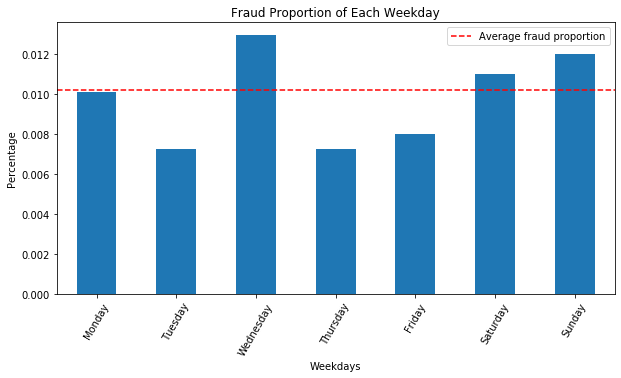

In [189]:
plt.figure(figsize=(10,5))
y_weekday_smooth.plot(kind='bar')
plt.xticks(range(7),
           ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
           rotation=60)
plt.axhline(y_avg, color='r', linestyle='--')
plt.xlabel('Weekdays')
plt.ylabel('Percentage')
plt.title('Fraud Proportion of Each Weekday')
plt.legend(['Average fraud proportion'])
plt.show()

In [191]:
tt.to_csv('Create variables_traintest.csv', index=False)
oot.to_csv('Create variables_oot.csv', index=False)

In [38]:
finalDF = df[['record','date','amount']]

for val in attributes:
    df1 = df[['record','date','amount', val]].copy()
    df2 = df1.copy()
    lags = [0, 1, 3, 7, 14, 30]
    df3 = df1.merge(df2, on=val)

    ##### 2. frequency variables #####
    for lag in lags:
        temp = df3[(df3['record_x']>=df3['record_y']) & (df3['date_x']<=df3['date_{}'.format(lag)])]
        tempCount = temp[['record_x','record_y']].groupby('record_x').count().reset_index()
        date_lags = 'ps_{}d_count'.format(lag)
        tempCount.columns = ['record', date_lags] 
        # df1 = df1.merge(tempCount, left_on='record',right_on='record')

KeyError: 'date_0'